### Практическое задание

- Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.
- Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Задание 1

In [2]:
X, y = load_diabetes(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [17]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 2

# Шаг
eta = 0.19

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [19]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [20]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Количество деревьев')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

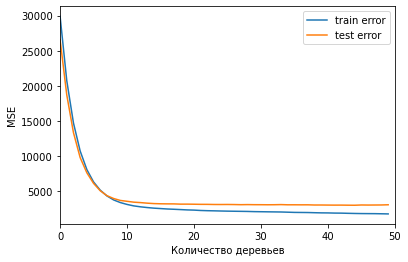

In [21]:
get_error_plot(n_trees, train_errors, test_errors)

In [23]:
def depth_tree_log(depth, X_train, X_test, y_train, y_test):
    n_trees = 10
    coefs = [1] * n_trees
    eta = 0.19
    train_finally_errors = []
    test_finally_errors = []
    for i in range(1,depth+1):
        max_depth = i
        trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
        train_finally_errors.append(train_errors[-1])
        test_finally_errors.append(test_errors[-1])
    plt.xlabel('Глубина дерева')
    plt.ylabel('MSE')
    plt.xlim(1, depth)
    plt.plot(list(range(1,depth+1)), train_finally_errors, label='train error')
    plt.plot(list(range(1,depth+1)), test_finally_errors, label='test error')
    plt.legend(loc='upper right')
    plt.show()

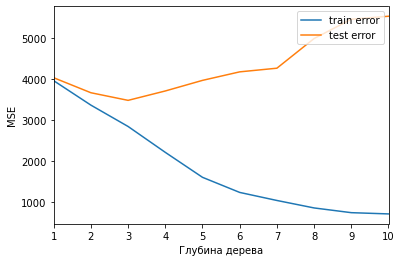

In [24]:
depth_tree_log(10, X_train, X_test, y_train, y_test)

Как мы видим при увеличении глубины дерева происходит жесточайшее переобучение. Уже после глубины 3, ошибка на тесте начинает изменяться в обратную сторону, при этом на трейн выборке ошибка продолжает падать. Таким образом, как и при большом количестве деревьев, так и при большой глубине алгоритм продолжает уменьшать ошибку на тренеровочной выборке до 0. Однако при увеличении количества деревьев ошибка на тестовой выборке выхоит на плато, что приводит к нецелесообразности строить дополнительные деревья, т.к. прироста генерализации мы не наблюдаем. В то время, как при увеличении глубины мы фактически "портим" свой алгоритм полностью подгоняя его под тренеровочные данные, после чего он способен адекватно выдавать решения на новых данных. 

### Задание 2


In [40]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        
        ind = np.random.choice(len(X_train), len(X_train) // 2, replace=False)
        
        
        if len(trees) == 0:
            
            
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[ind], y_train[ind])
            
            train_errors.append(mean_squared_error(y_train[ind], gb_predict(X_train[ind], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train[ind], trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[ind], bias(y_train[ind], target))
            
            train_errors.append(mean_squared_error(y_train[ind], gb_predict(X_train[ind], trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [41]:
n_trees = 50
coefs = [1] * n_trees
max_depth = 3
eta = 0.19

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

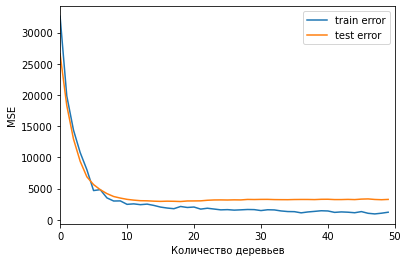

In [42]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что, как и при обычном стохастическом спуске показатели точности колеблятся, однако в итоге выходят на плато.